This starter notebook makes use of the pandas dataframe generated from Tendo EDA notebook and uses the file called 'df_all.csv'

Using this file we will sample 20% of the data to create a sample submission.

In [1]:
%%capture
!pip install fastcore fastai2 nbdev -q

     |████████████████████████████████| 194kB 8.7MB/s 
     |████████████████████████████████| 51kB 6.8MB/s 


# Imports

In [0]:
from fastai2.text.all import *
from fastai2.tabular.all import *
import pandas as pd

from pathlib import Path

In [0]:
ALL = 'df_all.csv'
FILENAME='df_sample.csv'

In [0]:
df_all = pd.read_csv(Path(f'{ALL}'))

In [0]:
df_sample = df_all.sample(frac=0.2, random_state=42)

In [80]:
len(df_sample)

16983

In [0]:
#In order to reproduce this, please uncomment and execute this cell and continue from the DataBlock section
df_sample.to_csv('df_sample.csv', index=False)

# Loading Data

In [0]:
df = pd.read_csv(Path(f'{FILENAME}'))

In [65]:
len(df),list(df.columns.values)

(84916,
 ['Title',
  'Description',
  'Image_id',
  'Product_id',
  'Prdtypecode',
  'Prdlbl',
  'image_path'])

In [66]:
df.sample(n=3)

,Title,Description,Image_id,Product_id,Prdtypecode,Prdlbl,image_path
78739,Alimentation Chargeur Secteur Officiel Sony Pour Sony Playstation 2 Slim Ps2 Pstwo,NaN,1186557830,3032960250,2462,Entertainment,Rakuten/dataset/image/image_training/image_1186557830_product_3032960250.jpg
53316,6 Numéros De La Revue Mad Movies.,NaN,1230866174,3642604587,2403,Books,Rakuten/dataset/image/image_training/image_1230866174_product_3642604587.jpg
58667,Madkanao Hélicoptère 5116 Prise Xt60 De La Batterie Zop 11.1v 1500mah 3s 40c Pour La Partie D'hélicoptère D'avion De Voiture De Rc,ZOP 11.1V 1500Mah 3S 40C Batterie XT60 Prise pour hélicoptère d&#39;avion de voiture RC Description de la pièce: Batterie rechargeableHaute capacité et haute capacitéEmballage favorable à l&#39;environnementStable de sortie actuel protégez votre modèle RCDécharge durable et à haut débit durable Facile à installer et durableType de produit: Batterie rechargeable lithium polymère batterie rechargeable paramètre: Puissance ZOP 11.1V 1500Mah 40CCapacité de la batterie: 1500MAhTaux de décharge en continu: 40C MAX 60Ctaille de la batterie: 110g Connecteur: XT60 plugL&#39;emballage comprend: 1 pile,1328578347,4250646061,1280,Child,Rakuten/dataset/image/image_training/image_1328578347_product_4250646061.jpg


In [0]:
df['Description'].fillna(' ', inplace=True)

In [68]:
df.sample(n=3)

,Title,Description,Image_id,Product_id,Prdtypecode,Prdlbl,image_path
70714,Another Statuette 1/8 Misaki Mei 19 Cm,Statuette en PVC haute qualité à l'échelle 1/8 sur socle. Taille env. 19 cm en emballage boîte-fenêtre.,934916637,193529845,1140,Entertainment,Rakuten/dataset/image/image_training/image_934916637_product_193529845.jpg
82075,Sid Meier's Civilization Iv: Beyond The Sword - Ensemble Complet - Pc - Dvd - Win - Français,,946269034,56442955,40,Entertainment,Rakuten/dataset/image/image_training/image_946269034_product_56442955.jpg
11812,Elle N° 165 Du 24/01/1949 - Roman - L'inconnue De La Dune - Des Robes - De La Lingerie - Du Tricot.,,1007812478,435272454,2280,Books,Rakuten/dataset/image/image_training/image_1007812478_product_435272454.jpg


In [69]:
df.Prdtypecode.nunique()

27

In [0]:
df['Title'] = df['Title'].astype(str)
df['Description'] = df['Description'].astype(str)
df['Prdtypecode'] = df['Prdtypecode'].astype('category') 

In [71]:
df.dtypes

Title            object
Description      object
Image_id          int64
Product_id        int64
Prdtypecode    category
Prdlbl           object
image_path       object
dtype: object

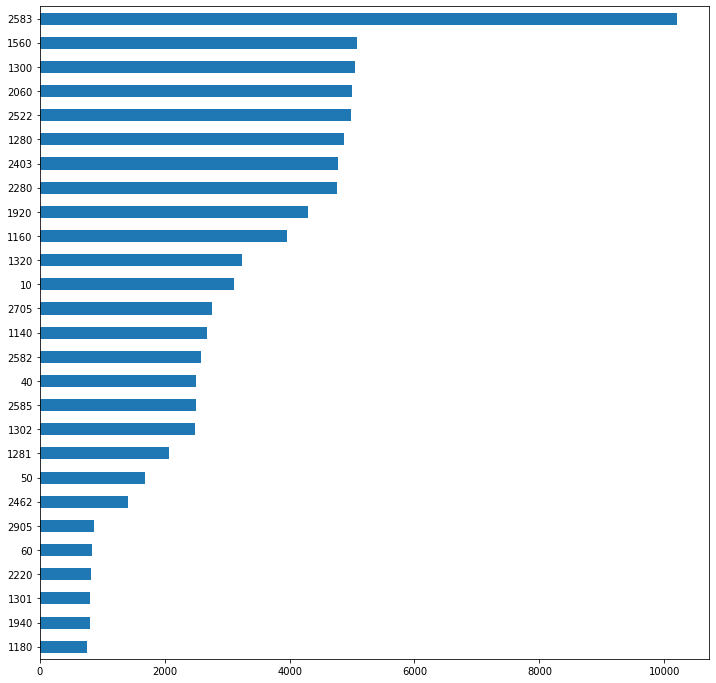

In [72]:
df.Prdtypecode.value_counts(ascending=True).plot.barh(figsize=(12,12))

# DataBlock

In [0]:
import pandas as pd
prod_sample= pd.read_csv('df_sample.csv')

## Language Model

In [0]:
txt_blk_lm = TextBlock.from_df(text_cols=['Title', 'Description'], 
                               is_lm=True, 
                               seq_len=72,                                 
                               tok_func=SpacyTokenizer, 
                               lang='fr', 
                               res_col_name='text')

In [0]:
db_lm = DataBlock(blocks=txt_blk_lm, 
                  get_x=ColReader('text'), 
                  splitter=RandomSplitter(valid_pct=0.1, seed=42))

In [16]:
dls_lm = db_lm.dataloaders(prod_sample, bs=64, seq_len=72)

In [17]:
b = dls_lm.one_batch(); len(b), len(b[0]), len(b[1]), b[0].shape, b[1].shape

(2, 64, 64, torch.Size([64, 72]), torch.Size([64, 72]))

In [18]:
dls_lm.show_batch()

,text,text_
0,xxbos xxfld 1 xxmaj jurassic xxmaj park ( version xxmaj us ) xxfld 2 xxbos xxfld 1 xxmaj galactic xxmaj destiny xxmaj the xxmaj board xxmaj game xxmaj of xxmaj galactic xxmaj xxunk xxfld 2 xxbos xxfld 1 xxmaj l' xxunk xxmaj emeraude 2010 ( xxunk - xxunk - xxunk - xxunk - saint xxmaj xxunk ) 2010 xxfld 2 xxbos xxfld 1 xxmaj xxunk xxmaj de xxmaj xxunk xxmaj xxunk -,xxfld 1 xxmaj jurassic xxmaj park ( version xxmaj us ) xxfld 2 xxbos xxfld 1 xxmaj galactic xxmaj destiny xxmaj the xxmaj board xxmaj game xxmaj of xxmaj galactic xxmaj xxunk xxfld 2 xxbos xxfld 1 xxmaj l' xxunk xxmaj emeraude 2010 ( xxunk - xxunk - xxunk - xxunk - saint xxmaj xxunk ) 2010 xxfld 2 xxbos xxfld 1 xxmaj xxunk xxmaj de xxmaj xxunk xxmaj xxunk - xxmaj
1,xxfld 1 xxmaj pokémon - xxunk / 131 - xxmaj xxunk - xxmaj reverse xxfld 2 xxbos xxfld 1 xxmaj arebos xxmaj coussin xxmaj de xxmaj protection xxmaj des xxmaj ressorts xxmaj pour xxmaj trampoline 366 cm xxmaj vert xxmaj clair xxfld 2 xxbos xxfld 1 85 xxmaj xxunk xxunk - lounge - xxmaj ready xxmaj to xxmaj run -- xxmaj union xxmaj pacific ( xxunk xxmaj yellow xxmaj gray xxmaj red,1 xxmaj pokémon - xxunk / 131 - xxmaj xxunk - xxmaj reverse xxfld 2 xxbos xxfld 1 xxmaj arebos xxmaj coussin xxmaj de xxmaj protection xxmaj des xxmaj ressorts xxmaj pour xxmaj trampoline 366 cm xxmaj vert xxmaj clair xxfld 2 xxbos xxfld 1 85 xxmaj xxunk xxunk - lounge - xxmaj ready xxmaj to xxmaj run -- xxmaj union xxmaj pacific ( xxunk xxmaj yellow xxmaj gray xxmaj red )
2,xxmaj hydratation xxmaj randonnée xxmaj camping xxunk xxmaj hp xxmaj stream xxfld 2 xxbos xxfld 1 xxmaj siège pour piscine tubulaire - xxmaj intex xxfld 2 xxbos xxfld 1 xxmaj européenne xxmaj home xxmaj decor 45 * 45 cm xxmaj coussin xxmaj en xxmaj lin xxmaj de xxmaj coton xxmaj couverture xxmaj jeter xxmaj taie f xxmaj xxunk xxfld 2 xxbos xxfld 1 xxmaj jouet xxmaj pour xxmaj animaux xxmaj chien xxmaj,hydratation xxmaj randonnée xxmaj camping xxunk xxmaj hp xxmaj stream xxfld 2 xxbos xxfld 1 xxmaj siège pour piscine tubulaire - xxmaj intex xxfld 2 xxbos xxfld 1 xxmaj européenne xxmaj home xxmaj decor 45 * 45 cm xxmaj coussin xxmaj en xxmaj lin xxmaj de xxmaj coton xxmaj couverture xxmaj jeter xxmaj taie f xxmaj xxunk xxfld 2 xxbos xxfld 1 xxmaj jouet xxmaj pour xxmaj animaux xxmaj chien xxmaj de
3,xxunk xxfld 2 xxbos xxfld 1 xxmaj matelas 150x210 xxmaj xxunk xxmaj alitea xxfld 2 xxbos xxfld 1 moakoada ® led 3d xxmaj lumineux xxmaj lumière xxmaj illusion xxmaj bureau xxmaj usb xxmaj lampe xxmaj de xxmaj nuit xxmaj lumière 7 xxmaj changement xxmaj de xxmaj coul xxmaj cadeaux xxfld 2 xxbos xxfld 1 xxmaj xxunk xxmaj of xxmaj the xxmaj xxunk xxfld 2 xxbos xxfld 1 xxunk xxmaj xxunk xxmaj barbecue,xxfld 2 xxbos xxfld 1 xxmaj matelas 150x210 xxmaj xxunk xxmaj alitea xxfld 2 xxbos xxfld 1 moakoada ® led 3d xxmaj lumineux xxmaj lumière xxmaj illusion xxmaj bureau xxmaj usb xxmaj lampe xxmaj de xxmaj nuit xxmaj lumière 7 xxmaj changement xxmaj de xxmaj coul xxmaj cadeaux xxfld 2 xxbos xxfld 1 xxmaj xxunk xxmaj of xxmaj the xxmaj xxunk xxfld 2 xxbos xxfld 1 xxunk xxmaj xxunk xxmaj barbecue xxmaj
4,xxmaj modèle xxmaj cadeaux xxmaj jouets éducatifs xxmaj shen xxunk xxfld 2 xxbos xxfld 1 xxmaj silicone xxmaj egg xxmaj xxunk xxmaj xxunk xxmaj xxunk xxmaj xxunk xxmaj cooking xxmaj kitchen xxmaj gadget xxmaj xxunk xxfld 2 xxbos xxfld 1 xxmaj diy xxmaj auvent xxunk xxmaj xxunk xxunk xxmaj cm xxfld 2 xxbos xxfld 1 xxmaj epuisette de surface xxmaj elite - xxmaj kokido xxfld 2 xxbos xxfld 1 xxmaj pokémon -,modèle xxmaj cadeaux xxmaj jouets éducatifs xxmaj shen xxunk xxfld 2 xxbos xxfld 1 xxmaj silicone xxmaj egg xxmaj xxunk xxmaj xxunk xxmaj xxunk xxmaj xxunk xxmaj cooking xxmaj kitchen xxmaj gadget xxmaj xxunk xxfld 2 xxbos xxfld 1 xxmaj diy xxmaj auvent xxunk xxmaj xxunk xxunk xxmaj cm xxfld 2 xxbos xxfld 1 xxmaj epuisette de surface xxmaj elite - xxmaj kokido xxfld 2 xxbos xxfld 1 xxmaj pokémon - 34
5,1 cache turbine robot dolphin xxfld 2 xxbos xxfld 1 xxmaj xk xxup xx

In [19]:
len(dls_lm.vocab)

7920

## Classification

In [0]:
txt_blk_cls = TextBlock.from_df(text_cols=['Title', 'Description'],
                                vocab=dls_lm.vocab,
                                is_lm=False, 
                                seq_len=72,                                 
                                tok_func=SpacyTokenizer, 
                                lang='fr', 
                                res_col_name='text')

In [0]:
db_cls = DataBlock(blocks=(txt_blk_cls,CategoryBlock),                  
                   get_x=ColReader('text'),
                   get_y=ColReader('Prdtypecode'),
                   splitter=RandomSplitter(valid_pct=0.15, seed=42))

In [18]:
db_cls.summary(prod_sample)

Setting-up type transforms pipelines
0                     Remplacement Bracelet En Cuir De Luxe Bracelet Bracelet Pour Fitbit Charge 2 Bk Stream  ...  Rakuten/dataset/image/image_training/image_1324199486_product_4236297869.jpg
1                                           Geometric Pillow Case Waist Cushion Cover Sofa Home Decor Cc3668  ...  Rakuten/dataset/image/image_training/image_1275151361_product_4004088812.jpg
2                       Simple Linen Creative Belle Oreiller Taie D'oreiller Taie D'oreiller Car Cover Cc400  ...  Rakuten/dataset/image/image_training/image_1275050731_product_4004067981.jpg
3                                       The Uncanny X-Men (Marvel Comics) - #296-297-298-299-300 - Comics Vo  ...  Rakuten/dataset/image/image_training/image_1150001483_product_2567988729.jpg
4      3pcs Non-Slip De Bain Tapis De Bain Tapis Cuisine Paillassons Décor Accessoires De Salle De Bain 1920  ...  Rakuten/dataset/image/image_training/image_1317085608_product_4211268511.jpg
...

Setting up Pipeline: ColReader -> Categorize

Building one sample
  Pipeline: ColReader -> Tokenizer -> Numericalize
    starting from
      Image_id                                                                                                                                                                                                                    1273141786
Product_id                                                                                                                                                                                                                  3993164358
Prdtypecode                                                                                                                                                                                                                       1560
Prdlbl                                                                                                                                                                

Setting up after_item: Pipeline: ToTensor
Setting up before_batch: Pipeline: partial
Setting up after_batch: Pipeline: 

Building one batch
Applying item_tfms to the first sample:
  Pipeline: ToTensor
    starting from
      (TensorText of size 30, TensorCategory(13))
    applying ToTensor gives
      (TensorText of size 30, TensorCategory(13))

Adding the next 3 samples

Applying before_batch to the list of samples
  Pipeline: partial
    starting from
      [(TensorText of size 30, TensorCategory(13)), (TensorText of size 27, TensorCategory(14)), (TensorText([   2,    4,    9,    8,   97,    8,  838,   16,    8, 3021,    8,   14,
           8, 1393,  815,    8,   21,  168,    4,   10]), TensorCategory(17)), (TensorText of size 29, TensorCategory(13))]
    applying partial gives
      [(TensorText of size 30, TensorCategory(13)), (TensorText of size 30, TensorCategory(14)), (TensorText of size 30, TensorCategory(17)), (TensorText of size 30, TensorCategory(13))]

Collating items in a 

In [22]:
dls_cls = db_cls.dataloaders(prod_sample, bs=64, seq_len=72)

# Language Model

In [23]:
learn_lm = language_model_learner(dls=dls_lm,
                                  arch=AWD_LSTM,
                                  metrics=[accuracy, Perplexity()])

In [114]:
Path('/root/.fastai/models/wt103-fwd').ls()

(#2) [Path('/root/.fastai/models/wt103-fwd/itos_wt103.pkl'),Path('/root/.fastai/models/wt103-fwd/lstm_fwd.pth')]

In [0]:
import pickle
with open('/root/.fastai/models/wt103-fwd/itos_wt103.pkl', 'rb') as f:
  orig_itos = pickle.load(f)

In [107]:
len(orig_itos)

60000

In [115]:
orig_itos[:100]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 'the',
 ',',
 '.',
 'of',
 'and',
 'in',
 'to',
 'a',
 '=',
 '"',
 'was',
 'on',
 '-',
 "'s",
 'as',
 'for',
 'that',
 'with',
 'by',
 '\n ',
 ')',
 '(',
 '\n \n ',
 'is',
 'his',
 'at',
 'he',
 'it',
 'from',
 'were',
 'an',
 'had',
 'which',
 'be',
 'this',
 'but',
 "'",
 'are',
 'not',
 'first',
 'their',
 'after',
 ';',
 'one',
 'her',
 '–',
 'also',
 'its',
 ':',
 'they',
 'two',
 'or',
 'have',
 'who',
 'new',
 'been',
 'has',
 'she',
 'when',
 'time',
 'during',
 'other',
 'would',
 'into',
 'all',
 'more',
 'while',
 'over',
 'i',
 'him',
 'game',
 'only',
 'later',
 'up',
 'most',
 'three',
 'about',
 'out',
 'between',
 'there',
 'than',
 'some',
 'film',
 'may',
 'no',
 'before',
 'made',
 'such',
 'season',
 'second',
 'where']

In [110]:
dls_lm.vocab

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxrep',
 'xxwrep',
 'xxup',
 'xxmaj',
 '1',
 '2',
 '-',
 'de',
 '/',
 'pour',
 'en',
 'à',
 'la',
 "d'",
 'et',
 '(',
 'cm',
 ')',
 'x',
 '+',
 'du',
 '3',
 ':',
 'le',
 'piscine',
 'jeu',
 'les',
 '.',
 'n°',
 'm',
 'lot',
 'avec',
 "l'",
 'coussin',
 '4',
 'des',
 '"',
 'kit',
 'enfants',
 'rc',
 'taie',
 'blanc',
 'a',
 'oreiller',
 'mm',
 'the',
 '&',
 '10',
 'bébé',
 'bois',
 'led',
 'sac',
 'g',
 'décor',
 '6',
 '5',
 'noir',
 'home',
 'bleu',
 'décoration',
 'noël',
 'drone',
 'notes',
 'carte',
 'jeux',
 'bâche',
 'of',
 'mini',
 '°',
 'n',
 'canapé',
 'portable',
 'journal',
 'acier',
 'couverture',
 '8',
 'par',
 'au',
 'générique',
 '12',
 'voiture',
 'console',
 '0',
 'dji',
 'spa',
 'magideal',
 'cadeau',
 'l',
 'jardin',
 'set',
 'gris',
 'cuisine',
 'lampe',
 'sur',
 'jouet',
 'h',
 'figurine',
 'pompe',
 'coton',
 'housse',
 'carnet',
 'tapis',
 ']',
 'table',
 'bulles',
 '…',
 'rouge',
 'lit',
 'tissu',
 '7',
 'jouets

In [112]:
old_tokens = list(set(dls_lm.vocab).intersection(orig_itos))
new_tokens = list(set(dls_lm.vocab) - set(orig_itos))
len(old_tokens), len(new_tokens)

(4081, 3835)

In [105]:
learn_lm.dls.train_ds

(#15285) [(TensorText([   2,    4,    9,    8,    0,  119,  119,    8, 3939,    8, 2821,    8,
         101,    8, 3010,    8,  214,    8,    0,   52,    8,   21,    4,   10]),),(TensorText([   2,    4,    9,    8,   15,    8,    0,    8,   18,    0,   11,    8,
        5351,    0,   11,    0,    7,   33, 4419,   27,    8,  176, 4910,    8,
          12,    8, 1947,    8,   19,    8,   18,  339,    4,   10]),),(TensorText([  2,   4,   9,   8,   0,  60,  73,   8, 149,   8, 890,   4,  10]),),(TensorText([   2,    4,    9,    8, 1533,    8,   14,    8,   53,    8, 1545,    8,
           0,    8, 1667,    8,   56, 1963,   11,  692,    8, 6510,    8,  566,
           8,  446,    4,   10]),),(TensorText([   2,    4,    9,    8,    0,    8,  174,    8,  289,    8, 2847,    8,
         108,    8,  159,  154,    8,  706,    8,   55,    4,   10]),),(TensorText([   2,    4,    9,    8, 5263,   12,  881,    8,    0,   11,   59,  185,
           4,   10]),),(TensorText([   2,    4,    9,    8,   89

SuggestedLRs(lr_min=0.15848932266235352, lr_steep=0.0831763744354248)

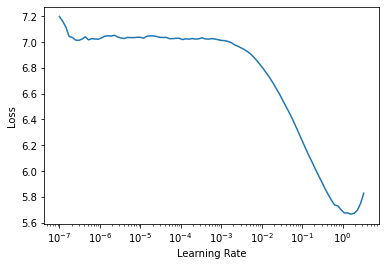

In [23]:
learn_lm.lr_find()

In [24]:
learn_lm.fine_tune(2,base_lr=8e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.633034,2.888071,0.562835,17.958632,00:26


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,2.689984,2.524642,0.584752,12.486424,00:28
1,2.384318,2.390096,0.603800,10.914546,00:28


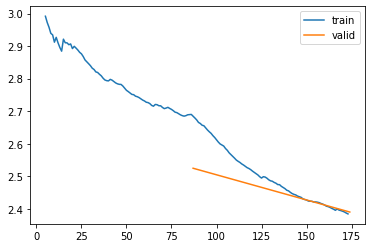

In [25]:
learn_lm.recorder.plot_loss()

In [0]:
learn_lm.save_encoder('fine_tuned_enc_2ep_8e_2lr')

# Classification

In [27]:
dls_cls.train_ds.vocab

(#2) [['xxunk', 'xxpad', 'xxbos', 'xxeos', 'xxfld', 'xxrep', 'xxwrep', 'xxup', 'xxmaj', '1', '2', '-', 'de', '/', 'pour', 'en', 'à', 'la', "d'", 'et', '(', 'cm', ')', 'x', '+', 'du', '3', ':', 'le', 'piscine', 'jeu', 'les', '.', 'n°', 'm', 'lot', 'avec', "l'", 'coussin', '4', 'des', '"', 'kit', 'enfants', 'rc', 'taie', 'blanc', 'a', 'oreiller', 'mm', 'the', '&', '10', 'bébé', 'bois', 'led', 'sac', 'g', 'décor', '6', '5', 'noir', 'home', 'bleu', 'décoration', 'noël', 'drone', 'notes', 'carte', 'jeux', 'bâche', 'of', 'mini', '°', 'n', 'canapé', 'portable', 'journal', 'acier', 'couverture', '8', 'par', 'au', 'générique', '12', 'voiture', 'console', '0', 'dji', 'spa', 'magideal', 'cadeau', 'l', 'jardin', 'set', 'gris', 'cuisine', 'lampe', 'sur', 'jouet', 'h', 'figurine', 'pompe', 'coton', 'housse', 'carnet', 'tapis', ']', 'table', 'bulles', '…', 'rouge', 'lit', 'tissu', '7', 'jouets', 's', '®', 'classique', '!', 'intex', 'collection', 'un', '[', 'nouveau', '100', 'ronde', 'for', 'support',

In [28]:
dls_cls.train.categorize.vocab

(#27) [10,40,50,60,1140,1160,1180,1280,1281,1300...]

In [0]:
learn_cls = text_classifier_learner(dls=dls_cls,
                                    arch=AWD_LSTM,
                                    metrics=[accuracy, error_rate])

In [0]:
learn_cls = learn_cls.load_encoder('fine_tuned_enc_2ep_8e_2lr')

SuggestedLRs(lr_min=0.05248074531555176, lr_steep=0.0831763744354248)

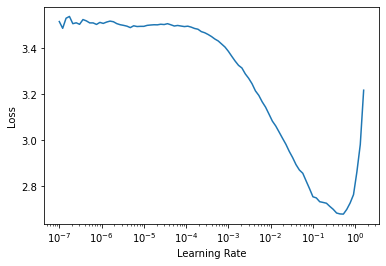

In [32]:
learn_cls.lr_find()

In [33]:
learn_cls.fit_one_cycle(4, lr_max=4e-2)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.590293,1.212402,0.622301,0.377699,00:22
1,1.431759,1.147877,0.654888,0.345112,00:22
2,1.302337,1.036491,0.676875,0.323125,00:22
3,1.219847,1.001180,0.690224,0.309776,00:22


SuggestedLRs(lr_min=0.00010000000474974513, lr_steep=1.9054607491852948e-06)

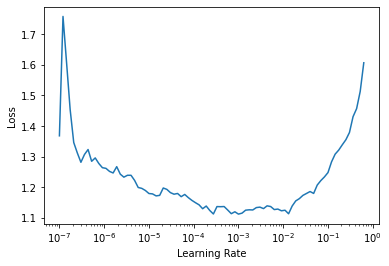

In [34]:
learn_cls.freeze_to(-2)
learn_cls.lr_find()

In [35]:
learn_cls.fit_one_cycle(5, lr_max=slice(5e-3/(2.6**4), 5e-3))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.124976,0.968514,0.696506,0.303494,00:23
1,1.095544,0.899773,0.713781,0.286219,00:22
2,0.999667,0.842387,0.735375,0.264625,00:23
3,0.898797,0.823150,0.742835,0.257165,00:23
4,0.851038,0.818149,0.744405,0.255595,00:23


SuggestedLRs(lr_min=6.309573450380412e-08, lr_steep=2.75422871709452e-06)

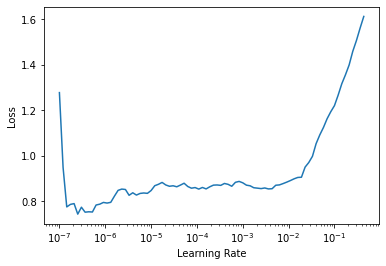

In [36]:
learn_cls.freeze_to(-3)
learn_cls.lr_find()

In [37]:
learn_cls.fit_one_cycle(2, lr_max=slice(5e-4/(2.6**4), 5e-4))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.806478,0.807907,0.749509,0.250491,00:23
1,0.814139,0.805442,0.747939,0.252061,00:24


In [0]:
learn_cls.unfreeze()

SuggestedLRs(lr_min=1.0964781722577755e-07, lr_steep=9.12010818865383e-07)

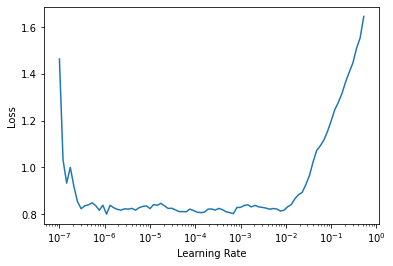

In [39]:
learn_cls.lr_find()

In [40]:
learn_cls.fit_one_cycle(3, lr_max=slice(5e-3/(2.6**4), 5e-3))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.838035,0.828289,0.736553,0.263447,00:25
1,0.715013,0.757715,0.770318,0.229682,00:25
2,0.604174,0.743098,0.770711,0.229289,00:25


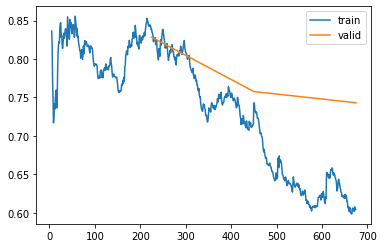

In [41]:
learn_cls.recorder.plot_loss()

In [61]:
inter = ClassificationInterpretation.from_learner(learn_cls)

In [63]:
inter.most_confused(min_val=3)

[(2705, 10, 34),
 (2705, 2403, 19),
 (2403, 10, 17),
 (2280, 2403, 16),
 (10, 2403, 15),
 (2582, 2060, 13),
 (1281, 1280, 12),
 (1280, 1300, 11),
 (1560, 2060, 11),
 (2060, 1560, 11),
 (10, 2705, 9),
 (40, 10, 8),
 (1180, 1140, 8),
 (1280, 1140, 8),
 (1320, 1280, 8),
 (2582, 1560, 8),
 (2583, 2585, 8),
 (1140, 1280, 7),
 (1300, 1280, 7),
 (1320, 1560, 7),
 (1320, 2060, 7),
 (1560, 2582, 7),
 (1920, 2060, 7),
 (2060, 2582, 7),
 (10, 2280, 6),
 (40, 1140, 6),
 (60, 2462, 6),
 (1180, 10, 6),
 (1280, 1281, 6),
 (1280, 1302, 6),
 (1280, 1320, 6),
 (1320, 1920, 6),
 (2585, 2583, 6),
 (1302, 1280, 5),
 (1560, 1320, 5),
 (1560, 1920, 5),
 (2060, 1320, 5),
 (2280, 10, 5),
 (2403, 2280, 5),
 (2522, 1560, 5),
 (2522, 2403, 5),
 (40, 2705, 4),
 (1140, 2403, 4),
 (1280, 2582, 4),
 (1281, 40, 4),
 (2403, 2705, 4),
 (40, 50, 3),
 (1160, 2280, 3),
 (1280, 10, 3),
 (1280, 1160, 3),
 (1281, 10, 3),
 (1281, 1160, 3),
 (1302, 1140, 3),
 (1302, 2582, 3),
 (1320, 10, 3),
 (2060, 1280, 3),
 (2060, 1920, 3),


In [0]:
learn_cls.save('final_learned')

# Evaluation

In [0]:
learn_cls.export(fname='rakuten-fastai2-defaults-sample.pkl')

In [0]:
TEST_FILENAME='x_test_task1_phase1.tsv'
test_df = pd.read_csv(TEST_FILENAME, sep='\t')

In [44]:
len(test_df)

937

In [45]:
test_df.isna().sum()

Integer_id       0
Title            0
Description    339
Image_id         0
Product_id       0
dtype: int64

In [0]:
test_df['Description'] = test_df['Description'].fillna(' ')

In [47]:
test_df.isna().sum()

Integer_id     0
Title          0
Description    0
Image_id       0
Product_id     0
dtype: int64

In [48]:
test_items = tokenize_df(df=test_df, text_cols=['Title', 'Description'], mark_fields=True, tok_func=SpacyTokenizer, lang='fr', res_col_name='text')

In [0]:
test_dl = learn_cls.dls.test_dl(test_items=test_items[0])

In [50]:
test_dl.show_batch()

,text
0,xxbos xxfld 1 xxmaj xxunk - 3 xxmaj monster xxmaj truck xxmaj xxunk xxmaj xxunk xxmaj traxxas xxunk 1 / 10 xxmaj brushless xxmaj wireless xxmaj xxunk xxunk xxmaj rtr gris - traxxas xxfld 2 xxunk xxunk xxunk couleur : xxunk / strong xxunk xxmaj gris xxunk / p xxunk xxunk p xxunk xxunk xxup xxunk xxmaj traxxas xxmaj brushless xxunk - 3 xxunk / p xxunk xxunk p xxunk type : xxmaj monster truck xxunk / p xxunk xxunk p xxunk nouveau système xxup xxunk xxunk / p xxunk xxunk p xxunk xxunk : électrique xxmaj brushless xxunk / p xxunk xxunk p xxunk echelle : 1 / 10 xxunk / p xxunk xxunk xxunk roues motrices xxunk / p xxunk xxunk p xxunk xxunk xxunk 3 voies xxunk xxunk / p xxunk xxunk p xxunk xxunk xxmaj traxxas 3 xxrep 3 0 mah 84 xxmaj xxunk xxup id
1,xxbos xxfld 1 xxmaj castlevania : xxmaj lords xxmaj of xxmaj shadow - xxmaj ultimate xxmaj edition - xxmaj jeu xxmaj en xxmaj téléchargement xxfld 2 xxunk xxunk xxunk xxunk p xxunk xxunk strong xxunk note : xxunk / strong xxunk un compte xxmaj xxunk et une xxunk internet sont xxunk pour xxunk xxunk et utiliser ce produit . xxunk / p xxunk xxmaj ultimate xxmaj edition xxunk xxunk xxunk castlevania : xxmaj lords of xxmaj shadow xxunk / strong xxunk xxunk / xxunk xxunk xxunk ? xxup dlc : xxunk / strong xxunk xxmaj xxunk marque le retour au xxunk château xxunk que xxmaj gabriel tente de xxunk en xxunk à la xxunk xxunk de la reine vampire . xxmaj le téléchargement xxunk trois niveaux et xxunk un xxunk coup de théâtre à xxunk du jeu . xxunk / xxunk xxunk résurrection ? xxup dlc : xxunk / strong
2,xxbos xxfld 1 xxmaj rollercoaster xxmaj tycoon xxmaj world - xxmaj jeu xxmaj en xxmaj téléchargement xxfld 2 xxup note : xxmaj code xxunk à utiliser xxunk sur un compte xxmaj xxunk xxunk xxunk xxmaj internet xxunk . xxunk xxmaj xxunk xxunk : xxmaj english xxmaj french xxmaj italian xxmaj xxunk xxmaj spanish xxunk - xxunk xxmaj xxunk xxmaj xxunk xxmaj xxunk xxmaj chinese xxmaj japanese xxmaj xxunk xxmaj xxunk xxmaj xxunk xxmaj xxunk xxmaj xxunk xxunk xxunk strong xxunk à xxup propos xxup du xxup jeu xxunk / strong xxunk xxunk b xxunk rollercoaster xxmaj tycoon xxmaj world ? xxunk / b xxunk est le nouvel xxunk de la xxunk xxunk xxup xxunk . xxmaj cette simulation de parc xxunk et de construction xxunk les éléments xxunk des xxunk xxunk que xxunk nouvelles xxunk comme de xxunk xxunk 3d xxunk de grands huit des xxunk xxunk des xxunk xxunk
3,xxbos xxfld 1 xxmaj train xxmaj simulator : xxmaj xxunk xxmaj xxunk xxmaj railway xxmaj route ( extension xxmaj dlc ) - xxmaj jeu xxmaj en xxmaj téléchargement xxfld 2 xxunk xxunk xxunk xxunk xxunk xxunk note : xxunk / strong xxunk xxmaj xxunk le jeu original xxunk b xxunk train xxmaj simulator xxunk / b xxunk pour xxunk . xxmaj un compte xxmaj xxunk et une xxunk internet sont xxunk pour xxunk xxunk et utiliser ce produit . xxunk / p xxunk xxunk p xxunk jeu en anglais xxunk / p xxunk à propos du jeu xxunk p xxunk le plus long chemin de fer du patrimoine de xxunk xxunk vie dans cette superbe extension xxmaj xxunk xxmaj xxunk xxmaj railway xxmaj route pour xxmaj train xxmaj simulator . xxunk / p xxunk xxunk p xxunk xxunk de ce que est à présent xxunk des lignes de chemin de
4,xxbos xxfld 1 moakoada ® jouets xxmaj en xxmaj peluche xxmaj jouet xxmaj développement xxmaj chambre xxmaj d' landau xxmaj douce xxmaj peluche xxmaj jouets xxmaj hanging xxmaj son xxfld 2 xxmaj jouets en peluche xxmaj jouet développement xxmaj chambre xxunk xxmaj hanging doux en peluche xxmaj jouets son xxmaj xxunk : xxmaj ce jouet de poussette est fait de peluche en coton doux pour le confort et la sécurité des bébés de nouveaux nés . xxmaj autour des xxunk se fixe xxunk xxunk xxunk poignées de siège bébé shopping poignées de panier xxunk xxunk suspendus lumineux colorés et mignons xxunk aider bébé à xxunk et à xxunk la vision du bébé . xxmaj améliorer la force des activités de main et du poignet et xxunk le développement des xxunk de la main et de xxunk le développement xxunk xxunk du bébé p

In [51]:
test_dl.one_batch()

(TensorText([[  2,   4,   9,  ...,  13, 892,   0],
         [  2,   4,   9,  ...,   1,   1,   1],
         [  1,   1,   1,  ...,   1,   1,   1],
         ...,
         [  1,   1,   1,  ...,   1,   1,   1],
         [  1,   1,   1,  ...,   1,   1,   1],
         [  1,   1,   1,  ...,   1,   1,   1]], device='cuda:0'),)

In [52]:
preds_raw, _, preds = learn_cls.get_preds(dl=test_dl, with_decoded=True)

In [53]:
learn_cls.dls.categorize.vocab

(#27) [10,40,50,60,1140,1160,1180,1280,1281,1300...]

In [54]:
learn_cls.dls.categorize.vocab[preds]

(#937) [1300,2583,2585,2585,2522,2280,2220,1302,2585,2585...]

In [0]:
test_df['Prdtypecode'] = learn_cls.dls.categorize.vocab[preds]

In [58]:
test_df.head()

,Integer_id,Title,Description,Image_id,Product_id,preds,Prdtypecode
0,0,Jeep Police - Gevarm-Gevarm,,1193217616,3136702026,1300,1300
1,1,Court Joyeux Noël En Peluche Taie Sofa Set Pad Décoration 18x18 Pouces Pillow Case 28537,Joyeux Noël en peluche court Taie Sofa Set Pad Décoration 18x18 pouces Spécification: Matériel: style court peluche: Taille de mode (approx.): 45x45cm La taille peut avoir un écart de 0.5-2cm en raison de produit par date. Entretien: Lavable à la main ou lavage à l&#39;eau froide au cycle délicat. Ne pas utiliser l&#39;eau de Javel. Fermeture à glissière cachée. Insérer est vendu séparément Il peut être utilisé pour décorer le salon faire paraître à la maison chaleur plus confortable. Remarque: S&#39;il vous plaît permettre erreur mineure en raison de la mesure manuelle. En raison de la di...,1323615566,4231863665,2583,2583
2,2,Sauna infrarouge Largo - 170 x 105 x 190 - Pin blanc,Dimensions : 150x105x190 cm ou 170x105x190 cm //// Nombre de places : 2 - 3 places assises //// Extérieur : Au choix : érable ou pin blanc ou cèdre rouge //// Intérieur : Au choix : érable ou pin blanc ou cèdre rouge //// Verre : Verre trempé 8-10 mm //// Température ajustable : Oui //// Contrôles et réglages : Panneau de commande tactile GD530 //// Multimédia : Radio station à mémoire avec connexion CD //// Poêle : Conduite chauffante //// Lumières : Lampe à lumière colorée Panneau en bois rétroéclairé.,1158121321,2695198357,2585,2585
3,3,BAGUE POUR LAME SOUS-SOLEUSE G. ET D.,,1096607258,1657064583,2585,2585
4,4,Carnet De Notes Bloc-Notes Cahierindian Squelette Flamen Pr¿º Tre Sacrifice Totem Taustration Sch¿¿Ma Les Carnets De Travail Classique Sur Support Papier Cadeau Tissu,Taille: En format A5 (144 cm x 21 cm) Caract¿¿ristique: -Excellente durabilit¿¿ avec couverture solide design. 96 pages jaune pale (recto et verso) -Texture de papier de haute qualit¿¿: ¿¿crire facilement sur et assez ¿¿paisse.,1303625028,4159071068,2522,2522


In [0]:
test_df[['Integer_id', 'Image_id', 'Product_id', 'Prdtypecode']].to_csv('y_test_task1_phase1_pred.tsv', index=False, sep='\t')

In [0]:
TASK1_EVAL_COL = "Prdtypecode"
TASK2_EVAL_COL = "Image_id"
def evaluate_task_1(y_pred, y_test):
    y_test_array = np.array(y_pred[TASK1_EVAL_COL])
    y_pred_array = np.array(y_test[TASK1_EVAL_COL])

    score = f1_score(y_test_array, y_pred_array, average="macro")

    return score